# SwarmPRM  + Time

In [1]:
%matplotlib inline

## Road Map tests


#### Import and setup

In [2]:
import glob
from matplotlib import pyplot as plt
import numpy as np

from swarm_prm.envs.map import MapLoader
from swarm_prm.envs.instance import Instance
from swarm_prm.solvers.swarm_prm.macro.gaussian_utils import GaussianGraphNode
from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianPRM


### Visualizing Maps

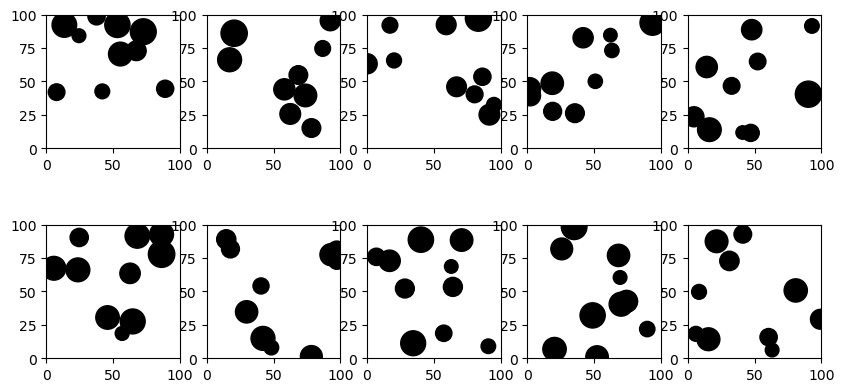

In [3]:
map_dir = "data/envs/maps/*"

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

# Visualize the first 10 maps
for idx, map_fname in enumerate(glob.glob(map_dir)[:10]):
    row = idx // 5
    col = idx % 5
    map_loader = MapLoader(map_fname)
    map = map_loader.get_map()
    map.visualize(ax=axs[row][col])

### Curated example

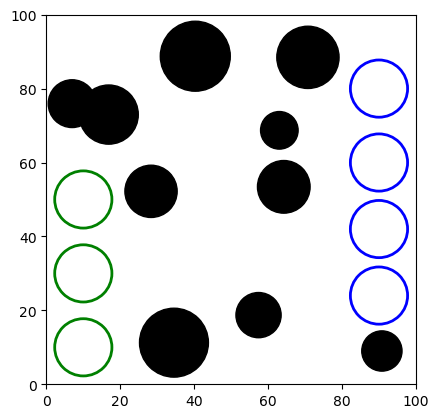

In [4]:
### PARAMETERS ###

# Map config
map_fname = "data/envs/maps/map_7.yaml"
map_loader = MapLoader(map_fname)
map = map_loader.get_map()
num_samples = 500 # number of sample points

# Agent config
num_agents = 10
agent_radius = 1


# Curated test instance
starts = np.array([[10, 10], [10, 30], [10, 50]])
goals = np.array([[90, 42], [90, 60], [90, 80], [90, 24]])

starts_weight = np.array([0.3, 0.4, 0.3])
goals_weight = np.array([0.1, 0.2, 0.4, 0.3])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(map, g_starts, g_goals, starts_weight, goals_weight)
instance.visualize()



#### SwarmPRM sampling


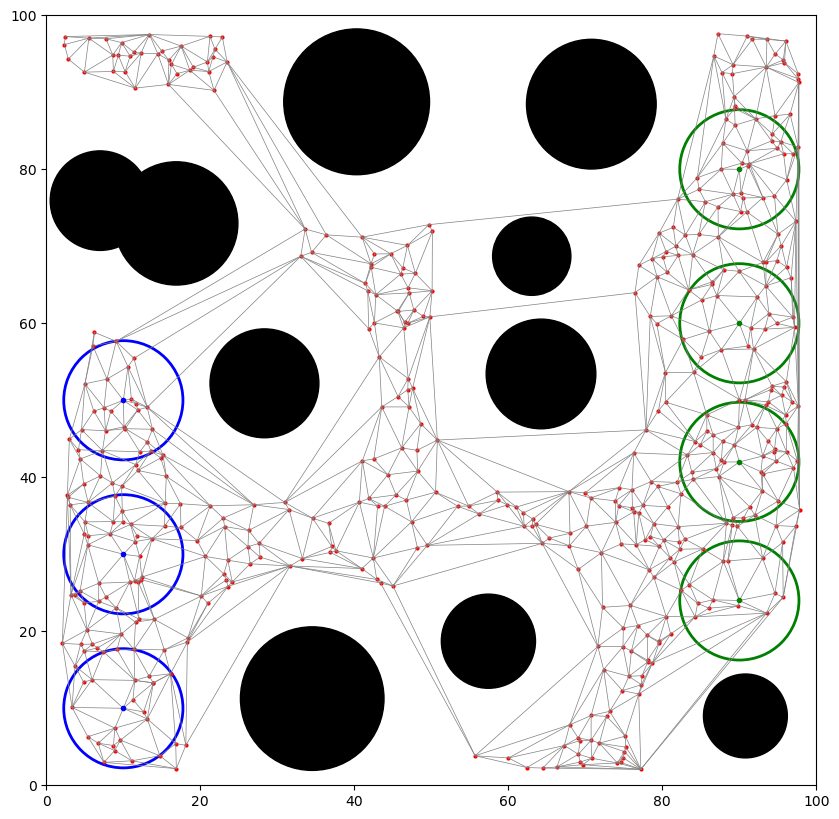

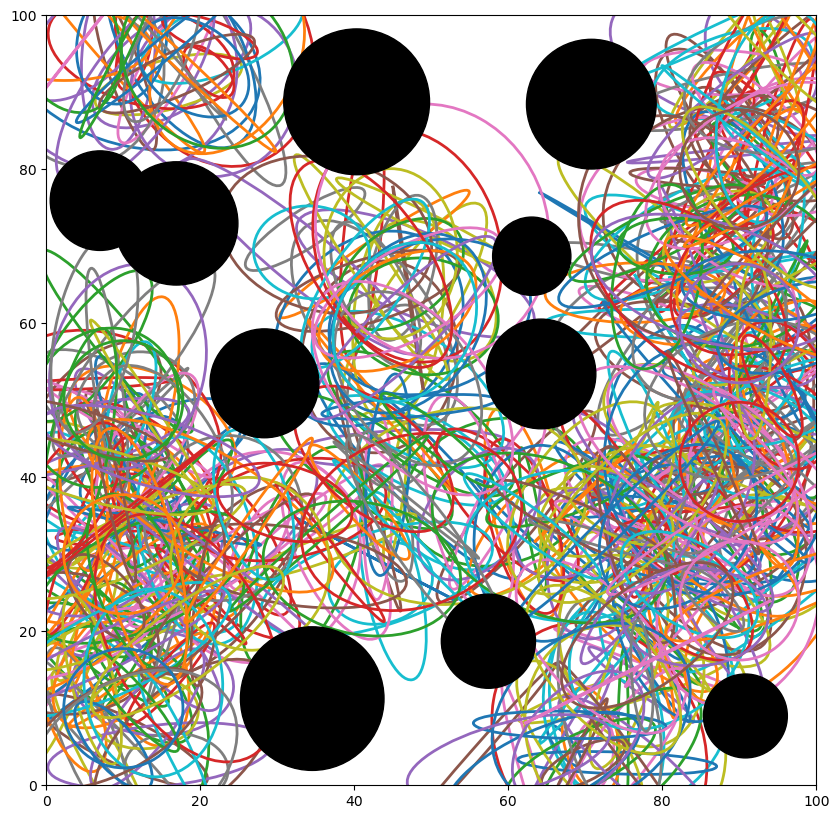

In [5]:
gaussian_prm = GaussianPRM(instance, num_samples)
gaussian_prm.sample_free_space(sampling_strategy="SWARMPRM")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")

#### Gaussian with uniform covariance

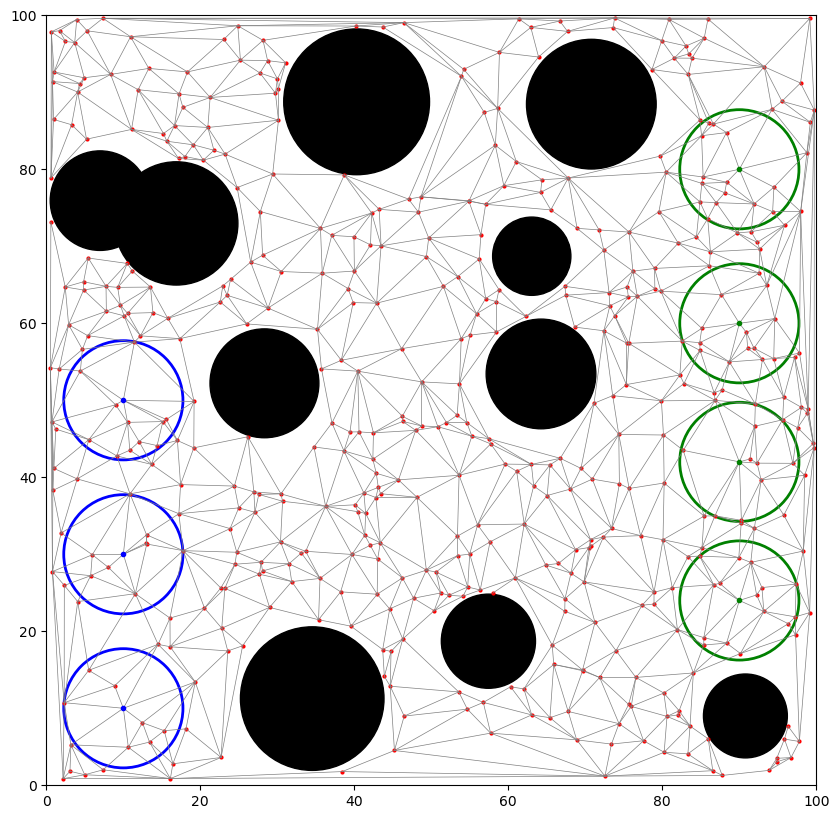

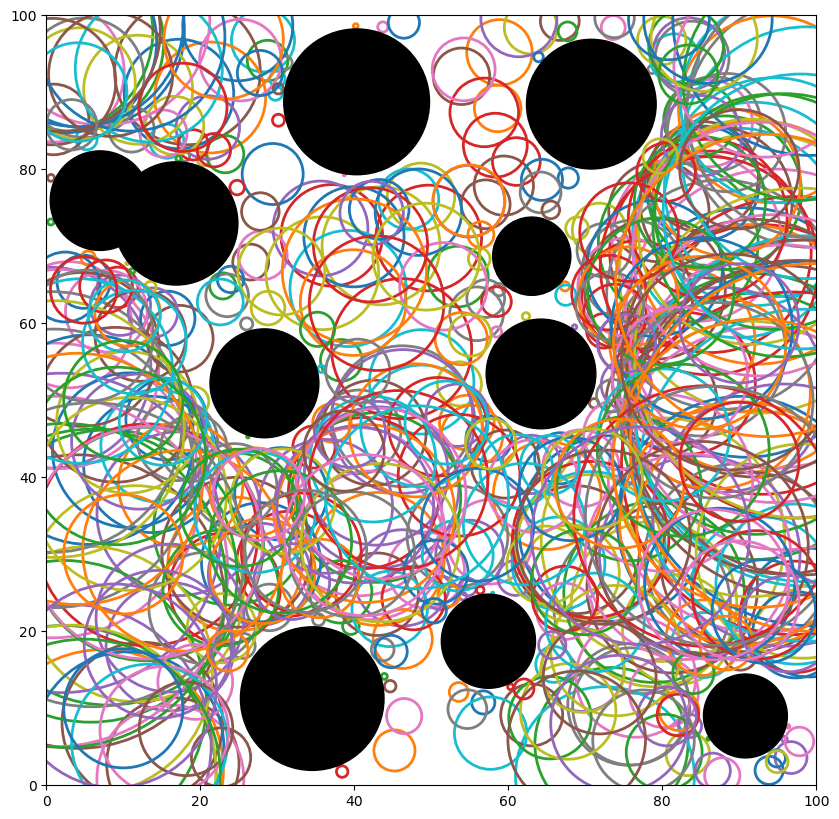

In [6]:
gaussian_prm = GaussianPRM(instance, num_samples)
gaussian_prm.sample_free_space(sampling_strategy="UNIFORM")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")

#### CVAR test

In [7]:

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm, chi2

from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianNode
from swarm_prm.envs.map import Map, CircleObstacle


def obstacle_gaussian_collision(obs: CircleObstacle, g_node: GaussianNode, alpha, thresh, ax) -> bool:
    """
        Using CVaR and threshold to test if node is too close to obstacle.
        Return True if CVaR is greater than the threshold.
        Reference: SwarmPRM
    """

    # Plot normal vector
    mean = -obs.get_dist(g_node.get_mean())
    v_normal = (obs.pos - g_node.get_mean()) / (np.linalg.norm(obs.pos - g_node.get_mean()))
    start_pos = g_node.get_mean()
    end_pos = start_pos - v_normal * mean
    vec = np.vstack([start_pos, end_pos]).T
    ax.plot(vec[0], vec[1])

    variance = v_normal.T @ g_node.covariance @ v_normal
    ita = norm(mean, variance)
    cvar = mean + ita.pdf(ita.ppf(1-alpha))/alpha * variance
    # print(cvar)
    return cvar > thresh

def visualize_g_node(g_node, ax, thresh, is_collision):
    # Visualize G nodes
    mean, cov = g_node.get_gaussian()
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors by descending eigenvalue
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # The angle of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # The width and height of the ellipse (2*sqrt(chi2_value*eigenvalue))
    chi2_value = chi2.ppf(thresh, 2)  # threshold confidence interval for 2 degrees of freedom (chi-squared value)
    width, height = 2 * np.sqrt(chi2_value * eigenvalues)
    if is_collision:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="red", fc='None', lw=2)
    else:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="blue", fc='None', lw=2)
    ax.add_patch(ellipse)


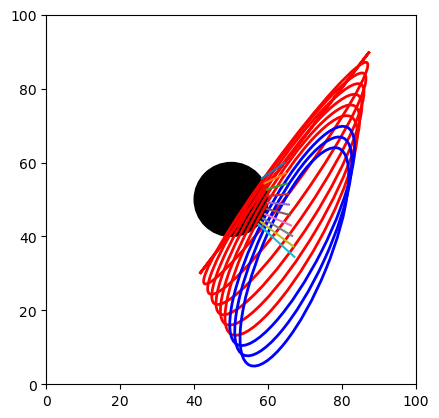

In [8]:

roadmap = Map(100, 100)
pos = np.array([50, 50])
obs = CircleObstacle(pos, 10)
thresh = -8
tolerance = 0.95
alpha = 0.95 
num_g_node = 10 

roadmap.add_obstacle(obs)
fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

temp = np.random.rand(2, 2) * 10
start_cov =  temp @ temp.T
temp = np.random.rand(2, 2) * 10
goal_cov =  temp @ temp.T

for i in range(num_g_node):
    mean = i / (num_g_node) * start_mean + (num_g_node - i) / num_g_node * goal_mean
    cov = i / (num_g_node) * start_cov + (num_g_node - i) / num_g_node * goal_cov

    g_node = GaussianNode(mean, cov)
    is_collision = obstacle_gaussian_collision(obs,  g_node, alpha, thresh, ax)
    visualize_g_node(g_node, ax, tolerance, is_collision)


### TEG (NetworkX) test

max flow 143
timestep 6
flow_dict {'VS': {'1_0': 0, '2_0': 0, '3_0': 0, '4_0': 0, '5_0': 0, '6_0': 0, '7_0': 0}, '1_0': {'105_1': 69, '349_1': 0, '400_1': 68, '203_1': 75, '286_1': 0, '389_1': 6}, '2_0': {'69_1': 0, '405_1': 0, '394_1': 0, '307_1': 0}, '3_0': {'222_1': 0, '276_1': 0, '226_1': 0, '175_1': 0, '465_1': 0, '81_1': 0}, '4_0': {'37_1': 0, '133_1': 0, '41_1': 0, '414_1': 0, '200_1': 0, '341_1': 0}, '5_0': {'182_1': 0, '198_1': 0, '148_1': 0, '332_1': 0, '212_1': 0}, '6_0': {'257_1': 0, '27_1': 0, '422_1': 0, '218_1': 0}, '7_0': {'211_1': 0, '445_1': 0, '165_1': 0, '331_1': 0, '164_1': 0, '360_1': 0}, 'SS': {'1_0': 143, '2_0': 0}, '6_6': {'SG': 0, '6_5': 0}, 'SG': {}, '7_6': {'SG': 143, '7_5': 0}, '1_1': {'1_0': 75, '105_2': 0, '349_2': 0, '400_2': 0, '203_2': 0, '286_2': 0, '389_2': 0}, '2_1': {'2_0': 0, '69_2': 0, '405_2': 0, '394_2': 0, '307_2': 0}, '3_1': {'3_0': 0, '222_2': 0, '276_2': 0, '226_2': 0, '175_2': 0, '465_2': 0, '81_2': 0}, '4_1': {'4_0': 0, '37_2': 0, '133_2'

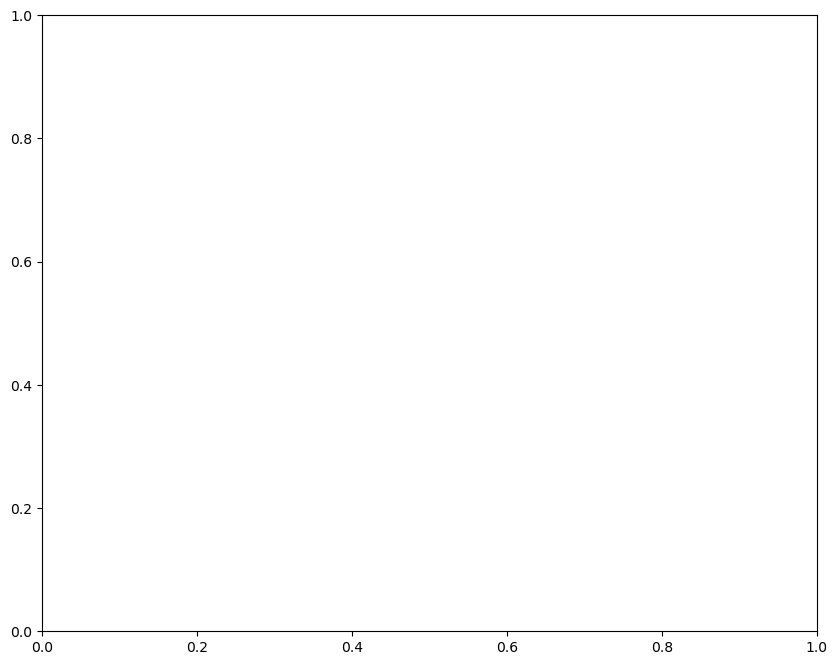

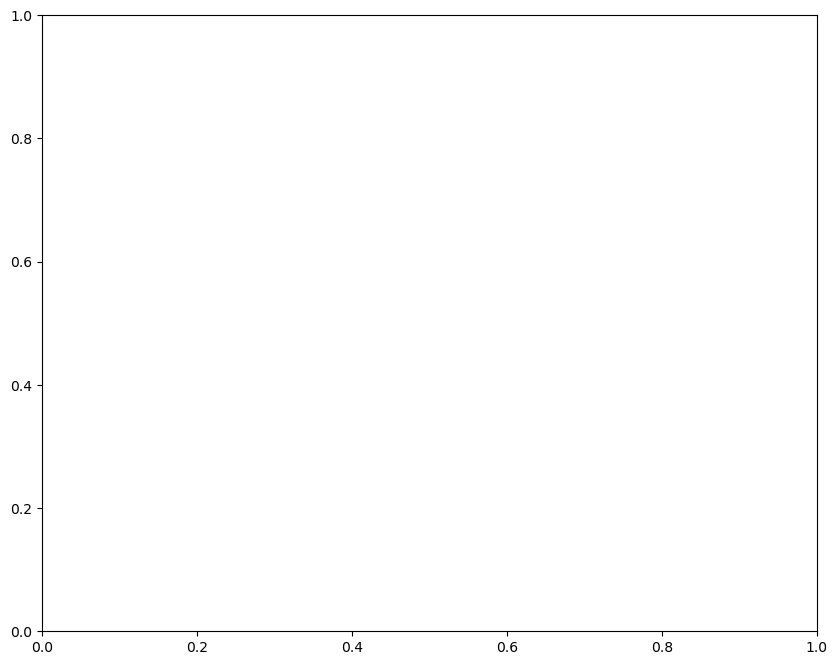

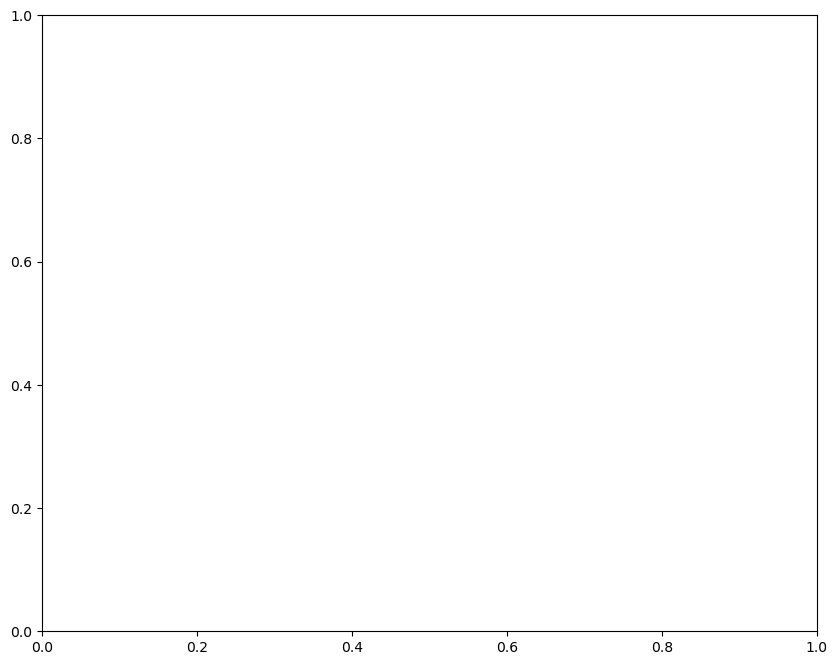

In [13]:
from swarm_prm.solvers.swarm_prm.macro.teg_nx import TEGGraph_NX
%run src/swarm_prm/solvers/swarm_prm/macro/teg_nx.py

teg_graph= TEGGraph_NX(gaussian_prm, agent_radius, target_flow=num_agents)
max_flow, flow_dict, timestep, teg, restricted_edges  = teg_graph.find_earliest_timestep()
print("max flow", max_flow)
print("timestep", timestep)
print("flow_dict", flow_dict)
assert max_flow is not None, "Unable to find solution within the given timesteps"
# teg_graph.visualize_teg(teg, restricted_edges)
for _ in range(3):
    fig, ax = plt.subplots(figsize=(10, 8))


### APR Test

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the potential field functions
def attractive_potential(x, goal, k_att=1.0):
    return k_att * np.linalg.norm(x - goal)

def repulsive_potential(x, obstacles, k_rep=100.0, d0=1.0):
    U_rep = 0
    for obs in obstacles:
        dist = np.linalg.norm(x - obs)
        if dist < d0:
            U_rep += k_rep * (1.0 / dist - 1.0 / d0) ** 2
    return U_rep

def potential_field(x, goal, obstacles):
    U_att = attractive_potential(x, goal)
    U_rep = repulsive_potential(x, obstacles)
    return U_att + U_rep

# Generate PRM Graph
def create_prm_graph(nodes, edges):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    return G

# Define the pathfinding function using the potential field
def pathfinding(start, goal, graph, obstacles):
    path = [start]
    current = start
    while np.linalg.norm(np.array(current) - np.array(goal)) > 0.1:
        neighbors = list(graph.neighbors(current))
        if not neighbors:
            break
        best_next = None
        best_potential = float('inf')
        for neighbor in neighbors:
            potential = potential_field(np.array(neighbor), goal, obstacles)
            if potential < best_potential:
                best_potential = potential
                best_next = neighbor
        if best_next is None:
            break
        path.append(best_next)
        current = best_next
    path.append(goal)
    return path

# Define the environment
nodes = [(0, 0), (1, 0), (1, 1), (0, 1), (0.5, 0.5)]
edges = [((0, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 1), (0, 1)), ((0, 1), (0, 0)), ((0, 0), (0.5, 0.5)), ((1, 0), (0.5, 0.5)), ((1, 1), (0.5, 0.5))]
start_positions = [(0, 0), (1, 1)]
goal_positions = [(1, 1), (0, 0)]
obstacles = [(0.5, 0.5)]  # For simplicity, consider one obstacle

# Create PRM graph
graph = create_prm_graph(nodes, edges)

# Find paths for each agent
paths = []
for start, goal in zip(start_positions, goal_positions):
    path = pathfinding(start, goal, graph, obstacles)
    paths.append(path)

# Visualization
plt.figure(figsize=(12, 8))
pos = {node: node for node in nodes}
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, edge_color='gray')

# Draw paths
for path in paths:
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2, style='dashed')

# Draw obstacles
if obstacles:
    plt.scatter(*zip(*obstacles), color='black', marker='x', s=100, label='Obstacles')

# Draw start and goal points
for start, goal in zip(start_positions, goal_positions):
    plt.scatter(*start, color='blue', marker='o', s=100, edgecolor='black', label='Start' if 'Start' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.scatter(*goal, color='green', marker='s', s=100, edgecolor='black', label='Goal' if 'Goal' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title("PRM Graph with Agent Paths")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()
